In [1]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output

In [3]:
dane = "/DATA/shared/datasets/cifar10/cifar10_test.tfrecord"
dane_train = "/DATA/shared/datasets/cifar10/cifar10_train.tfrecord"

## Input pipeline

Zastosowano tu następującą strategie:

 - do trenowania używamy kolejki zarządzanej przez tensorflow
 - to testowania, pobieramy z kolejki dane w postaci tablic numpy i przekazujemy je do tensorflow z użyciem `feed_dict`

### net

In [4]:
def read_data(filename_queue):
    reader = tf.TFRecordReader()
    _, se = reader.read(filename_queue)
    f = tf.parse_single_example(se,features={'image/encoded':tf.FixedLenFeature([],tf.string),
                                            'image/class/label':tf.FixedLenFeature([],tf.int64),
                                            'image/height':tf.FixedLenFeature([],tf.int64),
                                            'image/width':tf.FixedLenFeature([],tf.int64)})
    image = tf.image.decode_png(f['image/encoded'],channels=3)
    image.set_shape( (32,32,3) ) 
    return image,f['image/class/label']

In [5]:
tf.reset_default_graph()

In [6]:
fq = tf.train.string_input_producer([dane_train])
image_data, label = read_data(filename_queue=fq)

In [7]:
batch_size = 128
images, sparse_labels = tf.train.shuffle_batch( [image_data,label],batch_size=batch_size,
                                               num_threads=2,
                                               capacity=1000+3*batch_size,
                                               min_after_dequeue=1000
                                               )
images = (tf.cast(images,tf.float32)-128.0)/33.0

## test queue


In [8]:
fq_test = tf.train.string_input_producer([dane])
test_image_data, test_label = read_data(filename_queue=fq_test)
batch_size = 128
test_images, test_sparse_labels = tf.train.batch( [test_image_data,test_label],batch_size=batch_size,
                                               num_threads=2,
                                               capacity=1000+3*batch_size,
                                               )
test_images = (tf.cast(test_images,tf.float32)-128.0)/33.0

In [9]:
net = tf.contrib.layers.conv2d( images, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.conv2d( net, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.conv2d( net, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.fully_connected(tf.reshape(net,[-1,2*2*32]), 32)
net = tf.contrib.layers.fully_connected(net, 10, activation_fn=None)
logits = net

xent = tf.losses.sparse_softmax_cross_entropy(sparse_labels,net)
loss = tf.reduce_mean( xent)

opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = opt.minimize(loss)

In [10]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

In [63]:
!ls cifar_convet.ckpt*

cifar_convet.ckpt-141000.data-00000-of-00001
cifar_convet.ckpt-141000.index
cifar_convet.ckpt-141000.meta
cifar_convet.ckpt-41000.data-00000-of-00001
cifar_convet.ckpt-41000.index
cifar_convet.ckpt-41000.meta


In [11]:
global_step = 0

In [12]:
if global_step>0:
    saver=tf.train.Saver()
    saver.restore(sess,'cifar_convet.ckpt-%d'%global_step)


In [ ]:
%%time
lvals = []


for i in range(global_step,global_step+200000):
    l, _ = sess.run([loss,train_op])
    if i%10==0:   
        clear_output(wait=True)
        print(l,i+1)
    if i%100==0:
        Images,Labels = sess.run([test_images,test_sparse_labels])
        predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
        r_test = np.sum(predicted==Labels)/Labels.size
        
        Images,Labels = sess.run([images,sparse_labels])
        predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
        r = np.sum(predicted==Labels)/Labels.size
        lvals.append([i,l,r,r_test])

global_step = i+1

0.172429 191881


In [14]:
global_step

200000

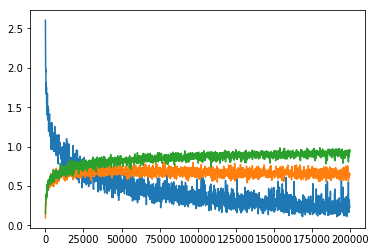

In [19]:
lvals = np.array(lvals)
plt.plot(lvals[:,0],lvals[:,1])

plt.plot(lvals[:,0],lvals[:,3])
plt.plot(lvals[:,0],lvals[:,2])

In [64]:
saver.restore(sess,'cifar_convet.ckpt')

INFO:tensorflow:Restoring parameters from cifar_convet.ckpt


In [16]:
sess.run(test_sparse_labels).shape

(128,)

In [17]:
sess.run(test_sparse_labels).shape

(128,)

In [18]:
label2txt = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck" ]


### Testing

Możemy wykorzystać `feed_dict` by wykonać graf operacji na ndanych testowych.


In [20]:
Images,Labels = sess.run([test_images,test_sparse_labels])

predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
np.sum(predicted==Labels)/Labels.size

0.6171875

automobile automobile


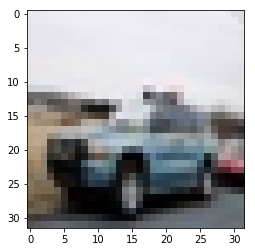

dog dog


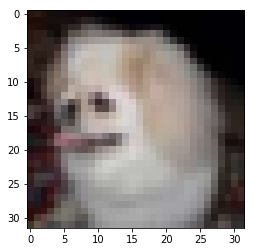

automobile airplane


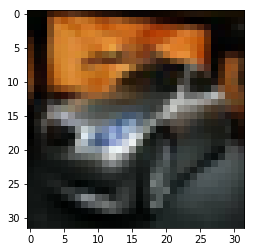

airplane airplane


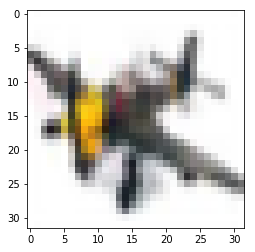

bird bird


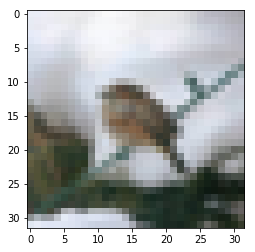

In [57]:
for ith in range(5):
    print (label2txt[Labels[ith]],(label2txt[predicted[ith]]))
    plt.imshow((Images[ith]*33+128).astype(np.uint8))
    plt.show()

In [78]:
%%time
l_lst =[]
for i in range(1):
    Images,Labels = sess.run([test_images,test_sparse_labels])
    predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
    rlst = np.sum(predicted==Labels)/Labels.size
print(rlst)

0.7734375
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 7.75 ms


In [17]:
saver = tf.train.Saver()

In [18]:
saver.save(sess,'cifar_convet.ckpt',global_step=global_step)

'cifar_convet.ckpt-200000'